In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from uav_active_sensing.config import PROCESSED_DATA_DIR
from uav_active_sensing.pytorch_dataloaders import TinyImageNetDataset
from uav_active_sensing.img_exploration_env import ImageExplorationEnv, RewardFunction
from uav_active_sensing.modeling.act_vit_mae import ActViTMAEForPreTraining
from uav_active_sensing.plots import visualize_tensor, visualize_reconstruction

import matplotlib.pyplot as plt

from torchvision import transforms
from torch.utils.data import DataLoader

from transformers import AutoImageProcessor


2025-02-06 17:42:08.416 | INFO     | uav_active_sensing.config:<module>:11 - PROJ_ROOT path is: /home/tcouso/uav_active_sensing


## Farama interface for custom ImageEnv

In [3]:

TINY_IMAGENET_PROCESSED_DIR = PROCESSED_DATA_DIR / "tiny_imagenet/tiny-imagenet-200"

tiny_imagenet_transform = transforms.Compose([
    # transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tiny_imagenet_train_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PROCESSED_DIR, split="train", transform=tiny_imagenet_transform
)
tiny_imagenet_val_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PROCESSED_DIR, split="val", transform=tiny_imagenet_transform
)

tiny_imagenet_train_loader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, shuffle=True)
tiny_imagenet_val_loader = DataLoader(tiny_imagenet_val_dataset, batch_size=1, shuffle=False)

In [4]:
image, _ = tiny_imagenet_train_dataset[15080]

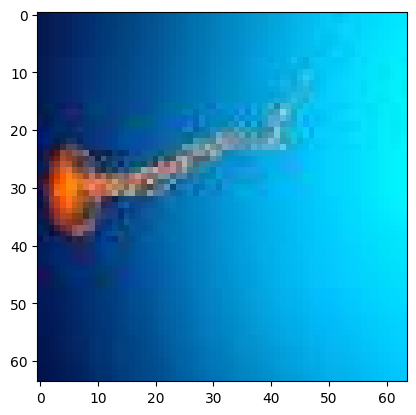

In [5]:
plt.imshow(image)

In [15]:
custom_model = ActViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base", use_fast=True)
reward_function = RewardFunction(custom_model)

inputs = image_processor(images=image, return_tensors="pt")
env = ImageExplorationEnv(inputs.pixel_values, reward_function, config=custom_model.config)

total_rewards = []
total_reward = 0
terminated = False

observation, info = env.reset()

# Random walk loop
while not terminated:
    action = env.action_space.sample()

    next_observation, reward, terminated, truncated, info = env.step(action)
    total_reward += reward.detach().numpy()

    if env.step_count % env.interval_reward_assignment == 0:
        print(f"Reward={total_reward}")
        total_rewards.append(total_reward)
        total_reward = 0

    observation = next_observation

env.close()

Reward=0.48794251680374146
Reward=0.46286192536354065
Reward=0.44934162497520447
Reward=0.5170786380767822
Reward=0.4728028476238251
Reward=0.4937966763973236
Reward=0.49727538228034973
Reward=0.5241231322288513
Reward=0.5062442421913147
Reward=0.5252084136009216
Reward=0.531309962272644
Reward=0.5306735038757324
Reward=0.529471755027771
Reward=0.5203685760498047
Reward=0.5235865712165833
Reward=0.5322782397270203
Reward=0.5377908945083618
Reward=0.5384093523025513
Reward=0.536200761795044
Reward=0.5336368680000305


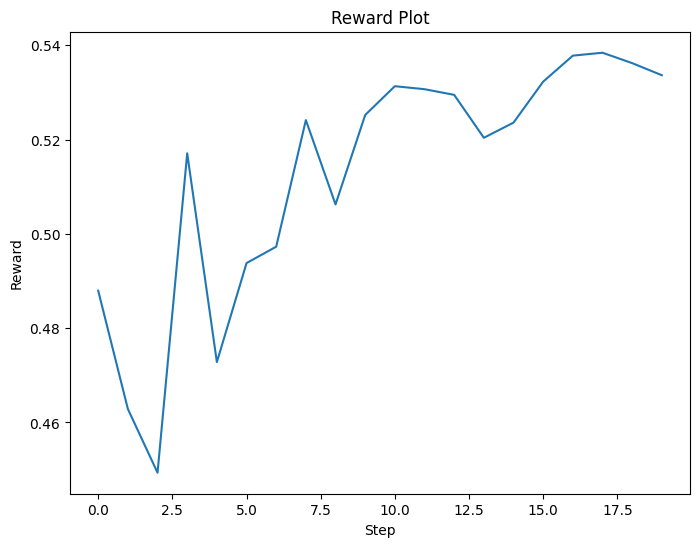

In [16]:
# Plot the rewards
plt.figure(figsize=(8, 6))  # Set the figure size to 8x6 inches
plt.plot(total_rewards)
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Reward Plot")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


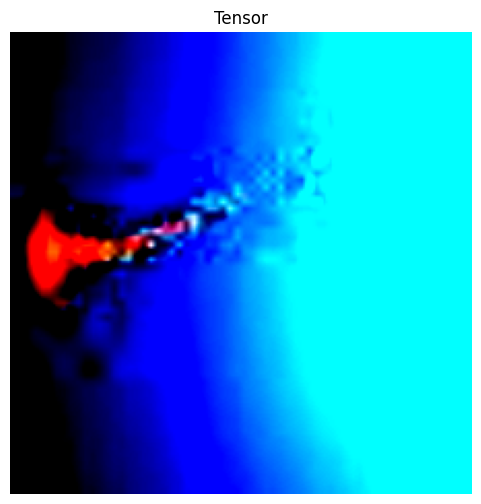

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.112914..2.631172].


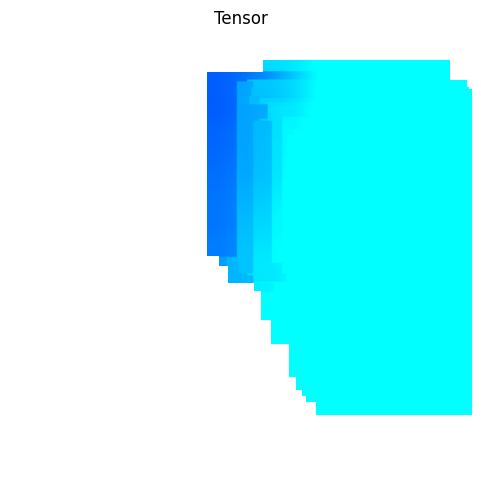

In [17]:
visualize_tensor(env.img)
visualize_tensor(env.sampled_img)

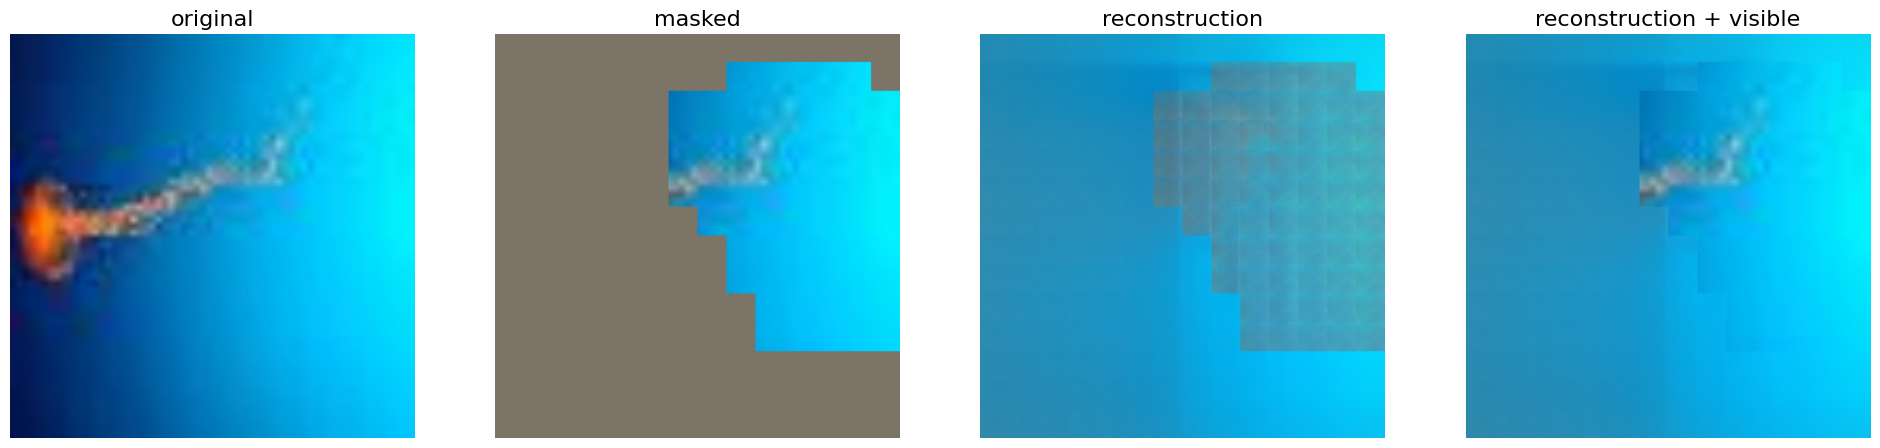

In [18]:
visualize_reconstruction(env.img, env.sampled_img, custom_model)

### Agents in the environment

In [14]:
from ray.rllib.algorithms.ppo import PPOConfig
# TODO: Register env
# TODO: Link env to a dataset. One batch per epoch

config = PPOConfig()
config.environment(env)
config.env_runners(num_env_runners=1)
config.training(
    gamma=0.9, lr=0.01, kl_coeff=0.3, train_batch_size_per_learner=256
)

algo = config.build()
algo.train()


# Structure of an epoch of RewardMAE

# 2.1 Assign a dataset to an environment, train agent with all images, store sampled images
# 2.2 Use sampled images to train MAE after that
# 2.3 Use updated MAE as a new reward function in step 2.1 of the next epoch. Wait for convergence to the optimal sampling strategy

# Agent: generate a sampling policy
# MAE: generate an image. The better the image, the greater the reward. If we fine tune MAE online, we can aspire to sampling policies that are better than random (regular MAE)

2025-02-06 17:47:08,971	WARNING algorithm_config.py:4726 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html


ValueError: <ImageExplorationEnv instance> is an invalid env specifier. You can specify a custom env as either a class (e.g., YourEnvCls) or a registered env id (e.g., "your_env").